Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Nate Schaefer"
COLLABORATORS = "Nick Hageman"

---

# Evaluating and Comparing Learners (Part I)

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, neighbors,
                     model_selection as skms,
                     linear_model, metrics)
#import ipywidgets as widgets
#from ipywidgets import interact

## Example use of a validation set

Below we load a sklearn dataset (either the diabetes dataset or the boston dataset) and call skms.train_test_split twice in order to obtain train, validation, and test sets with a 50%/25%/25% split. Note that in the second call to skms.train_test_split, we specified 33% for the test_size parameter in order for the validation set size to be equivalent to 25% of the overall dataset. In other words, since we want 25% of the samples (0.25)(overall), we need to determine the proprotion of the remaining 75% to extract:

25% of entire dataset = x% of 75% of entire dataset

(0.25)(all) = x(.75)(all)

(0.25) = x(.75)

--> x = 0.25/0.75 = 1/3 = .33

We also display the resulting proportions to make sure they are correct.

In [27]:
# obtain dataset
dataset_name = 'diabetes'
#dataset_name = 'boston'

if (dataset_name == 'boston'):
    dataset = datasets.load_boston()
else:    
    dataset = datasets.load_diabetes()

# separate test dataset from training/validation sets
(train_plus_validation_ftrs, 
 test_ftrs,
 train_plus_validation_tgt, 
 test_tgt) = skms.train_test_split(dataset.data,
                                   dataset.target,
                                   test_size=.25)

# separate training/validation sets
(train_ftrs,
 validation_ftrs,
 train_tgt,
 validation_tgt) = skms.train_test_split(train_plus_validation_ftrs,
                                         train_plus_validation_tgt,
                                         test_size=.33)

# display overall proportions
print(f'Train: {len(train_tgt)/len(dataset.target):.2f}')
print(f'Validation: {len(validation_tgt)/len(dataset.target):.2f}')
print(f'Test: {len(test_tgt)/len(dataset.target):.2f}')


Train: 0.50
Validation: 0.25
Test: 0.25


Below we specify a dictionary of regression models to try (linear regression, plus k-NN regression with different values for k) and apply them to the data in the validation set (after training on the training set) in order to determine the model with the lowest RMSE. 

In [28]:
# try different models and evaluate on validation set
models_to_try = {'lr': linear_model.LinearRegression(), 
                 '1-NN': neighbors.KNeighborsRegressor(n_neighbors=1),
                 '3-NN': neighbors.KNeighborsRegressor(n_neighbors=3),
                 '5-NN': neighbors.KNeighborsRegressor(n_neighbors=5),
                 '7-NN': neighbors.KNeighborsRegressor(n_neighbors=7),
                 '9-NN': neighbors.KNeighborsRegressor(n_neighbors=9),
                 '11-NN': neighbors.KNeighborsRegressor(n_neighbors=11),
                 '13-NN': neighbors.KNeighborsRegressor(n_neighbors=13),
                 '15-NN': neighbors.KNeighborsRegressor(n_neighbors=15)}

errors = {}
for model_name in models_to_try:
    fit = models_to_try[model_name].fit(train_ftrs, train_tgt)
    predictions = fit.predict(validation_ftrs)
    rmse = np.sqrt(metrics.mean_squared_error(validation_tgt,
                                              predictions))
    print(f'{model_name} RMSE: {rmse:.2f}')
    errors[model_name] = rmse  
    
# get model with minimum rmse error
best_model_name = min(errors, key=errors.get)  # uses dict.get function to sort -- on keys
print('Best model: ', best_model_name)
best_model = models_to_try[best_model_name]

lr RMSE: 58.61
1-NN RMSE: 77.99
3-NN RMSE: 64.92
5-NN RMSE: 61.81
7-NN RMSE: 59.89
9-NN RMSE: 59.94
11-NN RMSE: 59.67
13-NN RMSE: 60.13
15-NN RMSE: 60.11
Best model:  lr


After determining our "best" model above, we apply this model (after training on the data in the training set) to the data in the test set to get the final RMSE.

In [29]:
# evaluate 'best' model on withheld test set
fit = best_model.fit(train_ftrs, train_tgt)
predictions = fit.predict(test_ftrs)
rmse = np.sqrt(metrics.mean_squared_error(test_tgt,
                                          predictions))
print(f'{best_model_name} RMSE: {rmse:.2f}')

lr RMSE: 55.37


## Example of overfitting/underfitting (from your textbook)

The code in this section comes from chapter 5 of your textbook (with only a few extremely minor modifications) to illustrate the concepts of overfitting and underfitting through the use of polynomial models of different degrees. 

,0,1,2,3,4,5,6,7,8,9
ftr,3.684211,-7.894737,-1.578947,-8.947368,4.736842,-3.684211,2.631579,-0.526316,1.578947,8.947368
tgt,25.996992,121.655167,0.293290,157.137260,40.913545,23.342603,10.287672,-0.711326,0.274195,157.811120


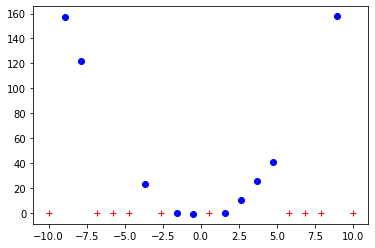

In [30]:
# set up train/test data
N = 20
ftr = np.linspace(-10, 10, num=N)                # ftr values
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N) # tgt = func(ftr)

(train_ftr, test_ftr,
 train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)

display(pd.DataFrame({"ftr":train_ftr, 
                      "tgt":train_tgt}).T)

plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr,  np.zeros_like(test_ftr), 'r+');

Below, we show how using sklearn's linear regression model with a single feature is equivalent to fitting a line to the data using np.polyfit (with a degree of 1).

In [31]:
# note: sklearn *really* wants 2D inputs (a table)
# so we use rehape here.
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1,1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1,1))
print(sk_preds[:3])

# fit predict evaluate a 1-D polynomial (a line)
#help(np.polyfit)
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

# the predictions come back the same
print("all close?", np.allclose(sk_preds, preds_one))

# and we can still use sklearn to evaluate it
mse = metrics.mean_squared_error
print(f'RMSE: {np.sqrt(mse(test_tgt, preds_one)):.2f}')

[59.63020811 34.92122341 52.2175127 ]
[59.63020811 34.92122341 52.2175127 ]
all close? True
RMSE: 77.48


Below we fit a polynomial with degree=2 (a parabola) to the training data and then evaluate the fit on the test data.

In [32]:
# fit predict evaluate a 2-D polynomial (a parabola)
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print(f'RMSE: {np.sqrt(mse(test_tgt, preds_two)):.2f}')

RMSE: 1.14


Below we fit a polynomial with degree=9 to the training test and then evaluate the fit on the test data. 

In [33]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print(f'RMSE: {np.sqrt(mse(test_tgt, preds_three)):.2f}')

RMSE: 249.79


Below we plot the polynomial fits above on the training data and testing data (as in the book). We also show the polynomials themselves using a more-refined grid as an extra plot. 

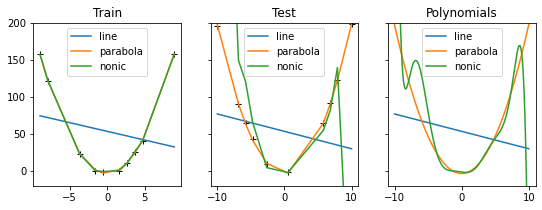

In [34]:
fig, axes = plt.subplots(1,3, figsize=(9,3), sharey=True)

labels = ['line', 'parabola', 'nonic']
models = [model_one, model_two, model_three]
train = (train_ftr, train_tgt)
test  = (test_ftr, test_tgt)

# plot the polynomial fits on the training data and testing 
# data (as in the book)
for ax, (ftr, tgt) in zip(axes[0:2], [train, test]):
    ax.plot(ftr, tgt, 'k+')
    for m, lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)
        
# also plot the polynomials themselves
ax = axes[2]
x = np.linspace(-10,10,1000)
for m, lbl in zip(models, labels):
    ax.plot(x,m(x),'-',label=lbl)
    

axes[1].set_ylim(-20, 200)
axes[0].set_title("Train")
axes[1].set_title("Test");
axes[2].set_title("Polynomials")
axes[0].legend(loc='upper center');
axes[1].legend(loc='upper center');
axes[2].legend(loc='upper center');

Below, we plot both the training error and testing error as a function of "complexity" of the polynomial fit (where complexity here is the degree of the polynomial). 

,Train Error,Test Error
Complexity,,
1,6.082370e+01,77.477805
2,1.151698e+00,1.144319
6,1.140426e+00,1.202440
9,1.082445e-12,249.785248


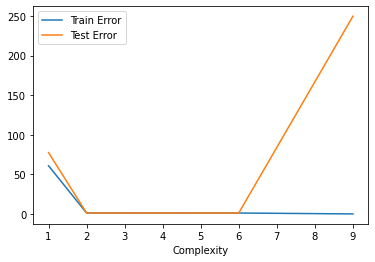

In [35]:
results = []
for complexity in [1,2,6,9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error = np.sqrt(mse(test_tgt, model(test_ftr)))
    results.append((complexity, train_error, test_error))
   
columns = ["Complexity", "Train Error", "Test Error"]
results_df = pd.DataFrame.from_records(results, 
                                       columns=columns,
                                       index="Complexity")

display(results_df)

results_df.plot();

## Assignment

In this assignment, you will practice using a separate validation set to select the best model (from at least five choices) for the regression task of predicting the number of wins of college football teams using features available from the 2019 College Football dataset. In the cell below, we obtain this dataset and reduce the number of features. However, unlike in prior notebooks, in this case, we add some additional features (just in case you would like to explore using different sets of features as part of your models). You do NOT need to modify this cell. However, if you would like, you may choose to use an entirely different set of features that you think would be potentially more predictive (however, try to avoid selecting features based on rankings or other features that would mostly be meaningful towards the end of the season). 

In [36]:
# load 2019 College Football dataset and extract desired information
cfb_orig_df = pd.read_csv("CFB2019.csv")
# extract bowl eligibility from the Wins-Loss column
# first separate Win-Loss into 2D array of Win and Loss strings
w_l = np.array([w_l_str.split('-') for w_l_str in cfb_orig_df['Win-Loss']])
# extract first column as wins (and convert to integers)
wins = w_l[:,0].astype(int)

# display candidate features (in case you want to pick a different set)
#for f in cfb_orig_df.columns:
#    print(f)
    
# extract some of the existing columns as a starting point for our smaller dataset
cfb_df = cfb_orig_df[['Rushing Yards per Game',
                      'Rush Yards Per Game Allowed',
                      'Pass Yards Per Game',
                      'Pass Yards Per Game Allowed',
                      'Points Per Game',
                      'Off Yards per Game',
                      'Yards Per Game Allowed',
                      'First Downs',
                      'Redzone Attempts']].copy()

# add the wins column
cfb_df['Wins'] = wins
# make the team column the index labels
cfb_df.index = cfb_orig_df['Team']

# display first five rows
display(cfb_df.head())

,Rushing Yards per Game,Rush Yards Per Game Allowed,Pass Yards Per Game,Pass Yards Per Game Allowed,Points Per Game,Off Yards per Game,Yards Per Game Allowed,First Downs,Redzone Attempts,Wins
Team,,,,,,,,,,
Air Force (Mountain West),298.5,100.5,123.2,219.1,34.1,421.8,319.6,286,54,11
Akron (MAC),47.6,213.5,195.6,200.4,10.5,243.2,413.9,155,26,0
Alabama (SEC),168.5,137.2,342.2,187.2,47.2,510.8,324.5,318,62,11
Appalachian St. (Sun Belt),231.4,129.4,201.7,206.7,38.8,433.1,336.1,295,60,13
Arizona (Pac-12),174.0,181.6,266.1,289.8,26.9,440.1,471.4,270,35,4


### Part I
Call skms.train_test_split twice to divide the dataset up into a training set (60% of the entire dataset), a validation set (20% of the entire dataset), and a test set (20% of the entire dataset). Take care in selecting your test_size parameters as once you split the dataset the first time you will no longer be working with the entire dataset once you split part of it a second time. Also, once you have divided the dataset into train/validation/test sets, compute/display the overall proportions of the number of samples of each set relative to the number of samples in the entire dataset to ensure you indeed have a 60%/20%/20% split (hint: see comments and code in first example).  

In [40]:

cfb_target = cfb_df['Wins']

cfb_features = cfb_df.drop(['Wins'],axis=1)



(train_plus_validation_ftrs, 
 test_ftrs,
 train_plus_validation_tgt, 
 test_tgt) = skms.train_test_split(cfb_features,
                                   cfb_target,
                                   test_size=.20)


(train_ftrs,
 validation_ftrs,
 train_tgt,
 validation_tgt) = skms.train_test_split(train_plus_validation_ftrs,
                                         train_plus_validation_tgt,
                                         test_size=.25)


print(f'Train: {len(train_tgt)/len(dataset.target):.2f}')
print(f'Validation: {len(validation_tgt)/len(dataset.target):.2f}')
print(f'Test: {len(test_tgt)/len(dataset.target):.2f}')

Train: 0.18
Validation: 0.06
Test: 0.06


### Part II
Using at least five regression models of your choice (e.g., linear regression plus k-NN regression with differing values of k; alternatively, you could try linear regression, or k-NN regression, with differing numbers of features to be included in the model), evaluate the model (using RMSE) on BOTH the training set and on the validation set from part I (in other words, while you will train using the training data, for each model, you will compute one RMSE value for the training set and one RMSE value for the validation set). (Note that in the first example above in the notebook, we had only evaluated on the validation set. Here, I want you to also evaluate on the training set as welll so that you can get an idea if your model is underfitting or overfitting. If both errors are high, the model is likely underfitting. If the training error is low, but the validation error is high, the model is likely overfitting.) Save the model with the lowest RMSE error on the validation set. 

In [43]:
models_to_try = {'lr': linear_model.LinearRegression(), 
                 '1-NN': neighbors.KNeighborsRegressor(n_neighbors=1),
                 '3-NN': neighbors.KNeighborsRegressor(n_neighbors=3),
                 '5-NN': neighbors.KNeighborsRegressor(n_neighbors=5),
                 '7-NN': neighbors.KNeighborsRegressor(n_neighbors=7),}

errors = {}
for model_name in models_to_try:
    fit = models_to_try[model_name].fit(train_ftrs, train_tgt)
    predictions = fit.predict(validation_ftrs)
    rmse = np.sqrt(metrics.mean_squared_error(validation_tgt,
                                              predictions))
    print(f'{model_name} RMSE: {rmse:.2f}')
    errors[model_name] = rmse  
    
# get model with minimum rmse error
best_model_name = min(errors, key=errors.get)  # uses dict.get function to sort -- on keys
print('Best model: ', best_model_name)
best_model = models_to_try[best_model_name]

lr RMSE: 1.47
1-NN RMSE: 1.81
3-NN RMSE: 1.90
5-NN RMSE: 1.78
7-NN RMSE: 1.88
Best model:  lr


### Part III

Evaluate (by computing/displaying the RMSE) of your saved "best" model from Part II above on your withheld test set. (Note: you likely will need to retrain the model on the training set if you didn't save the fitted models above.)

In [44]:
# evaluate 'best' model on withheld test set
fit = best_model.fit(train_ftrs, train_tgt)
predictions = fit.predict(test_ftrs)
rmse = np.sqrt(metrics.mean_squared_error(test_tgt,
                                          predictions))
print(f'{best_model_name} RMSE: {rmse:.2f}')

lr RMSE: 1.61
